<a href="https://colab.research.google.com/github/nifemi-alonge/EPF/blob/main/NG_EPF_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Questions

**Please note** that we might not have enough time to go through all of these questions during the interview. However, we will read through your answers before the interview, so please make sure to explain your reasoning in sufficient detail.

1. **Briefly explain conceptually how you would approach this problem**
2. **Present your final model, how the results compare to ground truth and your observations**
3. **Describe your feature selection process**
4. **Compare the performance of your models and describe how you selected the best performing one**
5. **What (if any) simplifying assumptions did you have to make? What additional insight/analysis/data would be required to make your model more robust?**
6. **How would you productionise a model run on a local PC on VBA which takes 10 hours runtime?**
7. **Given we combine separate analysis such as power system software (e.g. PLEXOS), external APIs, and local CSV files, what architectural and process consideration do you need to make when developing and running a model?**

## Answers

1. When trying to conduct forecasting you must consider what data you have available and the resources (analyst time, compute power) you have available. There are a number of both qualitative and quantitative forecasting approaches such as expert judgement, classical time-series models, machine learning and deep learning models.

  When approaching this issue I considered what techniques were appropriate given the provided historic time-series data which included price, demand and more. I also considered what was possible given the time-frame. From this I concluded that either time-series or machine learning methods were appropriate. Expert judgement was not appropriate given my knowledge level of electricity pricing and deep learning models are beyond the scope of this task for the following reasons (please see Appendix).

  I then explored ARIMA modelling, and machine learning methods including XGBoost and Random Forest. ARIMA modelling was not deemed appropriate following exploratory analysis (see appendix for further detail) and machine learning methods were chosen.

  I then considered how to create the models, tune them, get the results and evaluate them to decide on the final output.    
      
2. The final model is the linear regression model defined [here](https://colab.research.google.com/drive/1-0rtWLzQsw7RBblNlyY6pDIMorq7jjOo#scrollTo=bka7kiJ9GHWH&line=4&uniqifier=1) and run [here](https://colab.research.google.com/drive/1-0rtWLzQsw7RBblNlyY6pDIMorq7jjOo#scrollTo=aa5oJa2CItWR&line=5&uniqifier=1). The Root Mean Squared Error (RSME) and Mean Absolute Error (MAE) are both incredibly low, this indicates that my results are very close to the ground truth data. RMSE captures the average error between the predicted and true values, similarly MAE is the average of the absolute error. For both, a lower value indicates a better and less erroneous model. In addition, [this visualiation](https://colab.research.google.com/drive/1-0rtWLzQsw7RBblNlyY6pDIMorq7jjOo#scrollTo=AaYXalrxQ9DX&line=12&uniqifier=1) illustrates how good the predicted values are; they are exactly mapped to the true data.     

3. I used the inbuilt feature selection methods. Linear regression works by calculating coefficients that describe how much impact that variable is having on the predictor variable. I extracted these values and ranked them (see [this chart](https://colab.research.google.com/drive/1-0rtWLzQsw7RBblNlyY6pDIMorq7jjOo#scrollTo=1trT_3A2New2&line=1&uniqifier=1)). I did the same for the other models (XGBoost, Random Forest) and all showed that 'Price' had the largest impact on the model and the other variables only added a negligible impact, therefore they were removed from the final model.  

4. The linear regression model chosen uses only the historic electricity price data as a feature. It was selected because relative to all other models (the linear regression model with many features and the XGBoost and Random Forest models) it has the highest R squared. It is 1 meaning the data perfectly describes the variation in the data. The chosen model also has the lowest RSME and lowest MAE. RMSE and MAE are metrics commonly used to evaluate machine learning models. The error values for the XGBoost and Random Forest model are not high however the values for the linear model are many orders of magnitude lower (e-15). That said, the visualisation [here](https://colab.research.google.com/drive/1-0rtWLzQsw7RBblNlyY6pDIMorq7jjOo#scrollTo=00IjfmgYebWT&line=3&uniqifier=1) shows that all models have a high goodness-of-fit.

5. Linear regression has a number of assumptions there were assumed to be met - linearity between the independent and dependent variables (gb_price and gb_price_2020), independence of errors between observations, and homoscedasticity. A number of other variables would have been useful to use a features and may have had more impact than the ones tried - economic indicators, geopolitical indicators, generaton mix, supply of oil, fuel prices from key countries such as OPEC, interconnector supply, holiday indicators may better explain the trend in electricity prices. Other types of analysis could have included spatial regression (spatial lag and error models), GB prices are surely impacted by variables from neighbouring countries. This has not been picked up in the modelling. Could test for spatial autocorrelation and then run spatial regression. More exploration of the data to detect outliers, test for on-linear relationships.

6. Assess what the processes are and consider whether the technology stack could be changed. For instance R or Python are better at handling big data and have functionality - batching, generators - to speed up processing. Migrate to cloud infrastructure rather than local machine - AWS, GCP, Azure allow greater compute power to be harnessed to run a model much more efficiently. Then also allow model optimisation - monitoring indicators and implement fixes to improve performance (e.g. Azure ML). If not possible then optimise VBA - more efficient functions, reduce features (via dimensionality reduction). Should also check memory useage - if model is storing intermediate outputs removing this might free up memory and compute power.

7. Architecturally you need to consider interoperability - whether inputs and outputs from each system are accepted by the nest system - this can be determined using system testing and integration testing. Process wise the efficiency of the workflow should be closely monitored - e.g. if high levels of data pre-processing (costly) are needed to allow 2 processes to integrate with eachother this should be revised is possible. As much automation should be used (e.g. with appropriate software - Apache Airflow, schedudled jobs) to ensure efficiency however automated testing should be implemented so that errors are not carried forward. Logging would help track this. Security should be considered. Regular monitoring, maintenance, evaluation are also key.

## Set up

### Packages

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

In [111]:
import warnings
warnings.filterwarnings('ignore')

### Set paths

In [112]:
# Note: the paths are specific to my file directory
data_path = "/content/drive/MyDrive/Work/National_Grid_Lead_Data_Scientist_Interview/NG_coding_exercise_EPF/data/"
output_path = "/content/drive/MyDrive/Work/National_Grid_Lead_Data_Scientist_Interview/output/"

In [113]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load in data

### Data pre-processing function

In [114]:
# convert date to datetime type FUNCTION
def preprocess_datetime_column(df, datetime_column):
    # Check the data type of the 'Datetime (UTC)' column
    original_dtype = df[datetime_column].dtypes

    # Convert the datetime_column  to datetime with UTC timezone
    df[datetime_column] = pd.to_datetime(df[datetime_column], utc=True)

    # Check the data type of the datetime_columnafter conversion
    new_dtype = df[datetime_column].dtypes

    return original_dtype, new_dtype

### Demand

In [115]:
# demand data
demand_df = pd.read_csv(data_path + 'demand/' + 'demand.csv')
demand_df.head()

,Datetime,Country,Source,Demand (MW)
0,2015-01-01 00:00:00+00:00,BE,ENTSOe,9555.0
1,2015-01-01 01:00:00+00:00,BE,ENTSOe,9094.0
2,2015-01-01 02:00:00+00:00,BE,ENTSOe,8691.0
3,2015-01-01 03:00:00+00:00,BE,ENTSOe,8354.0
4,2015-01-01 04:00:00+00:00,BE,ENTSOe,8080.0


In [116]:
# convert date to datetime type
original_dtype, new_dtype = preprocess_datetime_column(demand_df, 'Datetime')

print(f"Original datetime column data type: {original_dtype}")
print(f"New datetime column data type: {new_dtype}")
demand_df.head()

Original datetime column data type: object
New datetime column data type: datetime64[ns, UTC]


,Datetime,Country,Source,Demand (MW)
0,2015-01-01 00:00:00+00:00,BE,ENTSOe,9555.0
1,2015-01-01 01:00:00+00:00,BE,ENTSOe,9094.0
2,2015-01-01 02:00:00+00:00,BE,ENTSOe,8691.0
3,2015-01-01 03:00:00+00:00,BE,ENTSOe,8354.0
4,2015-01-01 04:00:00+00:00,BE,ENTSOe,8080.0


In [7]:
# CHECK
demand_df['Datetime'].min()
demand_df['Datetime'].max()

Timestamp('2020-12-31 23:00:00+0000', tz='UTC')

### GB Demand

In [117]:
# create GB demand
gb_demand_df = demand_df[demand_df['Country'] == 'GB']

### Other Demand

In [118]:
be_demand_df = demand_df[demand_df['Country'] == 'BE']
dk_demand_df = demand_df[demand_df['Country'] == 'DK']
fr_demand_df = demand_df[demand_df['Country'] == 'FR']
de_demand_df = demand_df[demand_df['Country'] == 'DE']
ie_demand_df = demand_df[demand_df['Country'] == 'IE']
nl_demand_df = demand_df[demand_df['Country'] == 'NL']
# no Norway

In [119]:
# List of DataFrames
add_demand = [be_demand_df, dk_demand_df, fr_demand_df, de_demand_df,
                   ie_demand_df, nl_demand_df]

# Define a list of country names corresponding to each DataFrame
country_names = ['belgium', 'denmark', 'france', 'germany', 'ireland',
                 'netherlands']

# Initialize an empty DataFrame to store the merged data
add_demand_df = pd.DataFrame()

# Iterate through the list of DataFrames
for df, country_name in zip(add_demand, country_names):
    # Remove duplicate datetime values within each DataFrame
    df = df.drop_duplicates(subset='Datetime', keep='first')

    # Subset only the 'Datetime' and 'Demand (MW)' columns
    subset_df = df[['Datetime', 'Demand (MW)']]

    # Rename the 'Demand (MW)' column to the country-specific name
    subset_df.rename(columns={'Demand (MW)': f'{country_name}_demand'}, inplace=True)

    # Merge the subset DataFrame with the merged DataFrame
    if add_demand_df.empty:
        add_demand_df = subset_df
    else:
        # Perform a left merge to avoid duplicate rows
        add_demand_df = pd.merge(add_demand_df, subset_df, on='Datetime', how='left')

# Now you have a single DataFrame with datetime and demand columns for each country
add_demand_df.head()

,Datetime,belgium_demand,denmark_demand,france_demand,germany_demand,ireland_demand,netherlands_demand
0,2015-01-01 00:00:00+00:00,9555.0,3337.9,71506.350,47445.360,2849.0,11586.0
1,2015-01-01 01:00:00+00:00,9094.0,3223.2,71134.370,45923.710,2651.0,11338.0
2,2015-01-01 02:00:00+00:00,8691.0,3090.7,68840.400,44295.875,2412.0,10917.0
3,2015-01-01 03:00:00+00:00,8354.0,2953.4,65749.414,42868.043,2256.0,10473.0
4,2015-01-01 04:00:00+00:00,8080.0,2888.7,64041.330,42230.930,2170.0,10200.0


### GB Prices

In [120]:
# GB price data
gb_prices_df = pd.read_csv(data_path + 'prices/' + 'Great Britain.csv')
gb_prices_df.head()

,Country,ISO3 Code,Datetime (UTC),Price (GBP/MWhe)
0,Great Britain,GBR,01/01/2015 00:00,0
1,Great Britain,GBR,01/01/2015 01:00,0
2,Great Britain,GBR,01/01/2015 02:00,0
3,Great Britain,GBR,01/01/2015 03:00,0
4,Great Britain,GBR,01/01/2015 04:00,0


In [121]:
# convert date to datetime type
original_dtype, new_dtype = preprocess_datetime_column(gb_prices_df, 'Datetime (UTC)')

print(f"Original datetime column data type: {original_dtype}")
print(f"New datetime column data type: {new_dtype}")
gb_prices_df.head()

Original datetime column data type: object
New datetime column data type: datetime64[ns, UTC]


,Country,ISO3 Code,Datetime (UTC),Price (GBP/MWhe)
0,Great Britain,GBR,2015-01-01 00:00:00+00:00,0
1,Great Britain,GBR,2015-01-01 01:00:00+00:00,0
2,Great Britain,GBR,2015-01-01 02:00:00+00:00,0
3,Great Britain,GBR,2015-01-01 03:00:00+00:00,0
4,Great Britain,GBR,2015-01-01 04:00:00+00:00,0


In [13]:
# CHECK
gb_prices_df['Datetime (UTC)'].min()
gb_prices_df['Datetime (UTC)'].max()

Timestamp('2020-12-31 23:00:00+0000', tz='UTC')

### Other Prices

In [122]:
# other prices
be_prices_df = pd.read_csv(data_path + 'prices/' + 'Belgium.csv')
dk_prices_df = pd.read_csv(data_path + 'prices/' + 'Denmark.csv')
fr_prices_df = pd.read_csv(data_path + 'prices/' + 'France.csv')
de_prices_df = pd.read_csv(data_path + 'prices/' + 'Germany.csv')
ie_prices_df = pd.read_csv(data_path + 'prices/' + 'Ireland.csv')
nl_prices_df = pd.read_csv(data_path + 'prices/' + 'Netherlands.csv')
no_prices_df = pd.read_csv(data_path + 'prices/' + 'Norway.csv')

In [123]:
# convert date to datetime type

# List of DataFrames
add_prices = [be_prices_df, dk_prices_df, fr_prices_df, de_prices_df,
                   ie_prices_df, nl_prices_df, no_prices_df]

# Specify the column name
column_name = 'Datetime (UTC)'

# Apply the function to each DataFrame in the list
for df in add_prices:
    original_dtype, new_dtype = preprocess_datetime_column(df, column_name)
    print(f"Original 'Datetime (UTC)' column data type: {original_dtype}")
    print(f"New 'Datetime (UTC)' column data type: {new_dtype}")

Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]
Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]
Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]
Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]
Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]
Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]
Original 'Datetime (UTC)' column data type: object
New 'Datetime (UTC)' column data type: datetime64[ns, UTC]


In [124]:
# Define a list of country names corresponding to each DataFrame
country_names = ['belgium', 'denmark', 'france', 'germany', 'ireland',
                 'netherlands', 'norway']

# Initialize an empty DataFrame to store the merged data
add_prices_df = pd.DataFrame()

# Iterate through the list of DataFrames
for df, country_name in zip(add_prices, country_names):
    # Subset only the 'datetime' and 'price_' columns
    subset_df = df[['Datetime (UTC)', 'Price (EUR/MWhe)']]

    # Rename the 'price_' column to the country-specific name
    subset_df.rename(columns={'Price (EUR/MWhe)': f'{country_name}_price'}, inplace=True)

    # Merge the subset DataFrame with the merged DataFrame
    if add_prices_df.empty:
        add_prices_df = subset_df
    else:
        add_prices_df = pd.merge(add_prices_df, subset_df, on='Datetime (UTC)', how='outer')

# Now you have a single DataFrame with datetime and price columns for each country
add_prices_df.head()

,Datetime (UTC),belgium_price,denmark_price,france_price,germany_price,ireland_price,netherlands_price,norway_price
0,2015-01-01 00:00:00+00:00,34.94,18.29,34.94,17.93,138.97,34.94,27.36
1,2015-01-01 01:00:00+00:00,32.19,16.04,32.19,15.17,74.78,32.19,27.24
2,2015-01-01 02:00:00+00:00,28.05,14.60,23.53,16.38,72.99,28.05,27.16
3,2015-01-01 03:00:00+00:00,28.04,14.95,22.92,17.38,78.79,28.04,27.15
4,2015-01-01 04:00:00+00:00,34.26,14.50,34.26,16.38,84.79,34.26,27.30


### GB Weather

In [125]:
# GB weather data - daily
weather_df = pd.read_excel(data_path + 'weather/' + 'UK_daily_temp.xlsx')
weather_df.head()

,Datetime,Temperature (Celsius)
0,20150101,7.5
1,20150102,6.9
2,20150103,3.7
3,20150104,1.5
4,20150105,3.9


In [18]:
# CHECK
weather_df['Datetime'].min()
weather_df['Datetime'].max()

20201231

In [126]:
# convert date to datetime type
# Convert the integer column to a string
weather_df['Datetime'] = weather_df['Datetime'].astype(str)

# Use string formatting to create the desired format
weather_df['Datetime'] = pd.to_datetime(weather_df['Datetime'], format='%Y%m%d')

# Set the UTC timezone to the datetime column
weather_df['Datetime'] = weather_df['Datetime'].dt.tz_localize('UTC')

In [20]:
# CHECK
weather_df['Datetime'].min()
weather_df['Datetime'].max()

Timestamp('2020-12-31 00:00:00+0000', tz='UTC')

## Creating combined dataset

In [127]:
gb_dataset = pd.merge(gb_prices_df, gb_demand_df[['Demand (MW)', 'Datetime']], left_on='Datetime (UTC)', right_on='Datetime', how='left')
gb_dataset = pd.merge(gb_dataset, weather_df, left_on='Datetime (UTC)', right_on='Datetime', how='left')
gb_dataset = pd.merge(gb_dataset, add_prices_df, on='Datetime (UTC)', how='left')
gb_dataset = pd.merge(gb_dataset, add_demand_df, left_on='Datetime (UTC)', right_on='Datetime', how='left')

# forward fill temperature
gb_dataset['Temperature (Celsius)'].ffill(inplace=True)

# Drop the duplicate 'Datetime' columns
gb_dataset.drop(columns=['Datetime_x', 'Datetime_y'], inplace=True)

# Specify the columns you want to drop in a list
columns_to_drop = ['Country', 'ISO3 Code', 'Datetime']

# Use the drop method to remove the specified columns
gb_dataset.drop(columns=columns_to_drop, inplace=True)  # Set inplace=True to modify the DataFrame in place

# Define a dictionary to map old column names to new column names
column_rename_mapping = {
    'Datetime (UTC)': 'Datetime',
    'Price (GBP/MWhe)': 'gb_price',
    'Demand (MW)': 'gb_demand',
    'Temperature (Celsius)': 'gb_temp'
}

# Use the rename method to rename the specified columns
gb_dataset.rename(columns=column_rename_mapping, inplace=True)  # Set inplace=True to modify the DataFrame in place

gb_dataset.tail()

,Datetime,gb_price,gb_demand,gb_temp,belgium_price,denmark_price,france_price,germany_price,ireland_price,netherlands_price,norway_price,belgium_demand,denmark_demand,france_demand,germany_demand,ireland_demand,netherlands_demand
52603,2020-12-31 19:00:00+00:00,61.04,38697.5,-1.3,56.79,56.70,56.75,56.70,64.28,56.64,23.88,9794.50,4091.0,66763.0,51019.75,4259.0,12977.25
52604,2020-12-31 20:00:00+00:00,60.39,35833.0,-1.3,52.44,52.44,52.44,52.44,62.66,52.44,23.80,9386.25,3874.0,64102.0,48681.25,3954.0,12278.75
52605,2020-12-31 21:00:00+00:00,57.96,33026.5,-1.3,51.86,51.86,51.86,51.86,56.90,51.86,23.67,9582.00,3674.0,65097.0,47451.00,3689.5,11835.50
52606,2020-12-31 22:00:00+00:00,55.02,30714.5,-1.3,52.26,52.26,52.26,52.26,50.70,52.26,23.00,9683.50,3506.0,66913.0,45235.25,3467.5,11573.75
52607,2020-12-31 23:00:00+00:00,n/e,28975.0,-1.3,50.87,50.87,50.87,50.87,55.09,50.87,23.79,9296.00,3482.0,65761.0,44586.00,3423.5,11409.50


In [128]:
# dealing with missing price value fpr 2020-12-31 23:00:00+00:00
gb_dataset['gb_price'].dtypes # price has strings

# there is one price value with 'n/e' in it
# imputing this price value

# Find the index where 'n/e' appears in the Price column
index_to_replace = gb_dataset.index[gb_dataset['gb_price'] == 'n/e'].tolist()[0]

# Calculate the imputed value based on previous values (e.g., taking the mean)
# considering from 52603 as this is when value decline and are similar
previous_values = gb_dataset.loc[52603:index_to_replace - 1, 'gb_price']
imputed_value = np.mean(previous_values.astype(float))  # Assuming you want to use the mean

imputed_value = round(imputed_value, 2)

# Replace 'n/e' with the imputed value
gb_dataset.at[index_to_replace, 'gb_price'] = imputed_value

gb_dataset['gb_price'] = gb_dataset['gb_price'].astype(float)

gb_dataset.tail()

,Datetime,gb_price,gb_demand,gb_temp,belgium_price,denmark_price,france_price,germany_price,ireland_price,netherlands_price,norway_price,belgium_demand,denmark_demand,france_demand,germany_demand,ireland_demand,netherlands_demand
52603,2020-12-31 19:00:00+00:00,61.04,38697.5,-1.3,56.79,56.70,56.75,56.70,64.28,56.64,23.88,9794.50,4091.0,66763.0,51019.75,4259.0,12977.25
52604,2020-12-31 20:00:00+00:00,60.39,35833.0,-1.3,52.44,52.44,52.44,52.44,62.66,52.44,23.80,9386.25,3874.0,64102.0,48681.25,3954.0,12278.75
52605,2020-12-31 21:00:00+00:00,57.96,33026.5,-1.3,51.86,51.86,51.86,51.86,56.90,51.86,23.67,9582.00,3674.0,65097.0,47451.00,3689.5,11835.50
52606,2020-12-31 22:00:00+00:00,55.02,30714.5,-1.3,52.26,52.26,52.26,52.26,50.70,52.26,23.00,9683.50,3506.0,66913.0,45235.25,3467.5,11573.75
52607,2020-12-31 23:00:00+00:00,58.60,28975.0,-1.3,50.87,50.87,50.87,50.87,55.09,50.87,23.79,9296.00,3482.0,65761.0,44586.00,3423.5,11409.50


## Modelling

In [166]:
# define train test split and features for all models

gb_dataset.dropna(inplace=True)

# Split the data into training and testing datasets based on date
train_data = gb_dataset[gb_dataset['Datetime'].dt.year < 2020]  # Data from 2015-2019
test_data = gb_dataset[gb_dataset['Datetime'].dt.year == 2020]  # Data for 2020

# Define your feature columns
# full list of features available
features = ['gb_demand', 'gb_price', 'gb_temp', 'belgium_price',
                   'denmark_price', 'france_price', 'germany_price',
                   'ireland_price',	'netherlands_price',	'norway_price',
                   'belgium_demand',	'denmark_demand',	'france_demand',
                   'germany_demand',	'ireland_demand',	'netherlands_demand']

# final features after feature selection
features_final = ['gb_price']

### Model 1 - Linear Regression

In [174]:
# CREATE FUNCTION

def train_and_predict_linear_regression(features, output_name, save_csv, show_feature_importance):
    # Initialize and train a Linear Regression model
    model = LinearRegression()
    model.fit(train_data[features], train_data['gb_price'])  # Assuming you want to predict 'price'

    # Make predictions on the test set
    y_pred = model.predict(test_data[features])

    # Evaluate the model
    rmse = mean_squared_error(test_data['gb_price'], y_pred, squared=False)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    r2 = r2_score(test_data['gb_price'], y_pred)
    print(f"R-squared: {r2:.2f}")

    mae = mean_absolute_error(test_data['gb_price'], y_pred)
    print(f"Mean Absolute Error (MAE): {mae}")

    # Train the final model on the full dataset
    model.fit(gb_dataset[features], gb_dataset['gb_price'])  # Using the entire dataset for training

    # Predict electricity prices for 2020
    lr_predicted_2020_prices = model.predict(test_data[features])

    # Round predicted prices to 1 decimal place
    lr_predicted_2020_prices = np.round(lr_predicted_2020_prices, 1)

    # Create a DataFrame with datetime and predicted prices
    lr_results_df = pd.DataFrame({'Datetime': test_data['Datetime'], 'Price': lr_predicted_2020_prices})

    # Save results to CSV
    if save_csv:
      lr_results_df.to_csv(output_path + output_name, index=False)

    # Calculate feature importance
    coefficients = model.coef_
    feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

    # Sort by absolute coefficient value (importance)
    feature_importance = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)

    # Visualize feature importance
    if show_feature_importance:
      plt.figure(figsize=(10, 6))
      sns.barplot(x='Coefficient', y='Feature', data=feature_importance, orient='h')
      plt.xlabel('Coefficient (Feature Importance)')
      plt.ylabel('Feature')
      plt.title('Feature Importance in Linear Regression')
      plt.show()

    return lr_predicted_2020_prices

Root Mean Squared Error (RMSE): 3.982182114738973e-12
R-squared: 1.00
Mean Absolute Error (MAE): 3.3788864471682404e-12


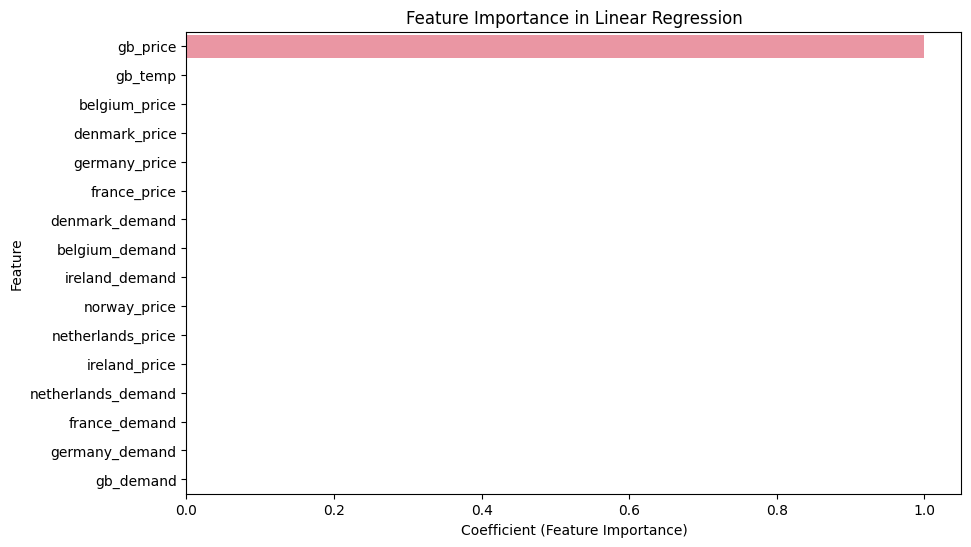

array([43.4, 41.1, 30. , ..., 58. , 55. , 58.6])

In [177]:
# run on features
train_and_predict_linear_regression(features, 'predicted_prices_2020_linear_reg.csv', save_csv=False, show_feature_importance=True)

In [178]:
# run on features_final
lr_predicted_2020_prices = train_and_predict_linear_regression(features_final,
                                                               'predicted_prices_2020_linear_reg.csv',
                                                               save_csv=True,
                                                               show_feature_importance=False)

Root Mean Squared Error (RMSE): 4.267768033635965e-15
R-squared: 1.00
Mean Absolute Error (MAE): 1.983102138674266e-15


### Model 2 - XGBoost

In [183]:
# CREATE FUNCTION

def train_and_predict_xgboost_model(features, output_name, save_csv, show_feature_importance):
    # Initialize and train an XGBoost Regressor model
    model = xgb.XGBRegressor(objective='reg:squarederror')
    model.fit(train_data[features], train_data['gb_price'])  # Assuming you want to predict 'price'

    # Get feature importances
    importances_xgb = model.feature_importances_

    # Match feature importances with feature names
    feature_names = train_data[features].columns
    feature_importance_xgb = dict(zip(feature_names, importances_xgb))

    # Sort feature importances by importance value
    sorted_feature_importance_xgb = sorted(feature_importance_xgb.items(), key=lambda x: x[1], reverse=True)

    # Print or visualize the sorted feature importances
    if show_feature_importance:
      print("Feature Importances:")
      for feature, importance in sorted_feature_importance_xgb:
          print(f"{feature}: {importance:.4f}")

    # Make predictions on the test set
    y_pred = model.predict(test_data[features])

    # Evaluate the model
    rmse = mean_squared_error(test_data['gb_price'], y_pred, squared=False)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    r2 = r2_score(test_data['gb_price'], y_pred)
    print(f"R-squared: {r2:.2f}")

    mae = mean_absolute_error(test_data['gb_price'], y_pred)
    print(f"Mean Absolute Error (MAE): {mae}")

    # Train the final model on the full dataset
    model.fit(gb_dataset[features], gb_dataset['gb_price'])  # Using the entire dataset for training

    # Predict electricity prices for 2020
    xgb_predicted_2020_prices = model.predict(test_data[features])

    # Round predicted prices to 1 decimal place
    xgb_predicted_2020_prices = np.round(xgb_predicted_2020_prices, 1)

    # Create a DataFrame with datetime and predicted prices
    xgb_results_df = pd.DataFrame({'Datetime': test_data['Datetime'], 'Price': xgb_predicted_2020_prices})

    # Save results to CSV
    if save_csv:
      xgb_results_df.to_csv(output_path + output_name, index=False)

    return xgb_predicted_2020_prices

In [29]:
# run on features
train_and_predict_xgboost_model(features,
                                'predicted_prices_2020_xgboost.csv',
                                save_csv=False,
                                show_feature_importance=True)

Root Mean Squared Error (RMSE): 1.279139944351928
R-squared: 0.99
Mean Absolute Error (MAE): 0.1388461884366451


In [184]:
# run on features_final
xgb_predicted_2020_prices = train_and_predict_xgboost_model(features_final,
                                                            'predicted_prices_2020_xgboost.csv',
                                                            save_csv=True,
                                                            show_feature_importance=False)

Root Mean Squared Error (RMSE): 1.2595395703540027
R-squared: 0.99
Mean Absolute Error (MAE): 0.1374199549198796


### Model 3 - Random Forest

In [181]:
# CREATE FUNCTION

def train_and_predict_random_forest_model(features, output_name, save_csv,show_feature_importance):
    # Initialize and train a Random Forest Regressor model
    model = RandomForestRegressor(random_state=42)
    model.fit(train_data[features], train_data['gb_price'])  # Assuming you want to predict 'price'

    # Get feature importances
    importances_rf = model.feature_importances_

    # Match feature importances with feature names
    feature_names = train_data[features].columns
    feature_importance_rf = dict(zip(feature_names, importances_rf))

    # Sort feature importances by importance value
    sorted_feature_importance_rf = sorted(feature_importance_rf.items(), key=lambda x: x[1], reverse=True)

    # Print or visualize the sorted feature importances
    if show_feature_importance:
      print("Feature Importances:")
      for feature, importance in sorted_feature_importance_rf:
          print(f"{feature}: {importance:.4f}")

    # Make predictions on the test set
    y_pred = model.predict(test_data[features])

    # Evaluate the model
    rmse = mean_squared_error(test_data['gb_price'], y_pred, squared=False)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    r2 = r2_score(test_data['gb_price'], y_pred)
    print(f"R-squared: {r2:.2f}")

    mae = mean_absolute_error(test_data['gb_price'], y_pred)
    print(f"Mean Absolute Error (MAE): {mae}")

    # Train the final model on the full dataset
    model.fit(gb_dataset[features], gb_dataset['gb_price'])  # Using the entire dataset for training

    # Predict electricity prices for 2020
    rf_predicted_2020_prices = model.predict(test_data[features])

    # Round predicted prices to 1 decimal place
    rf_predicted_2020_prices = np.round(rf_predicted_2020_prices, 1)

    # Create a DataFrame with datetime and predicted prices
    rf_results_df = pd.DataFrame({'Datetime': test_data['Datetime'], 'Price': rf_predicted_2020_prices})

    # Save results to CSV
    if save_csv:
      rf_results_df.to_csv(output_path + 'predicted_prices_2020_random_forest.csv', index=False)

    return rf_predicted_2020_prices

In [132]:
train_and_predict_random_forest_model(features,
                                      'predicted_prices_2020_random_forest.csv',
                                      save_csv=False,
                                      show_feature_importance=True)

Feature Importances:
gb_price: 0.9977
gb_demand: 0.0014
gb_temp: 0.0009
Root Mean Squared Error (RMSE): 1.3623000737972875
R-squared: 0.99
Mean Absolute Error (MAE): 0.09739575988018699


In [182]:
rf_predicted_2020_prices = train_and_predict_random_forest_model(features_final,
                                                                 'predicted_prices_2020_random_forest.csv',
                                                                 save_csv=True,
                                                                 show_feature_importance=False)

Root Mean Squared Error (RMSE): 1.285024512761696
R-squared: 0.99
Mean Absolute Error (MAE): 0.0920234128356026


## Visualisations (EDA and Evaluation)

### GB 2015-2020 Time Series

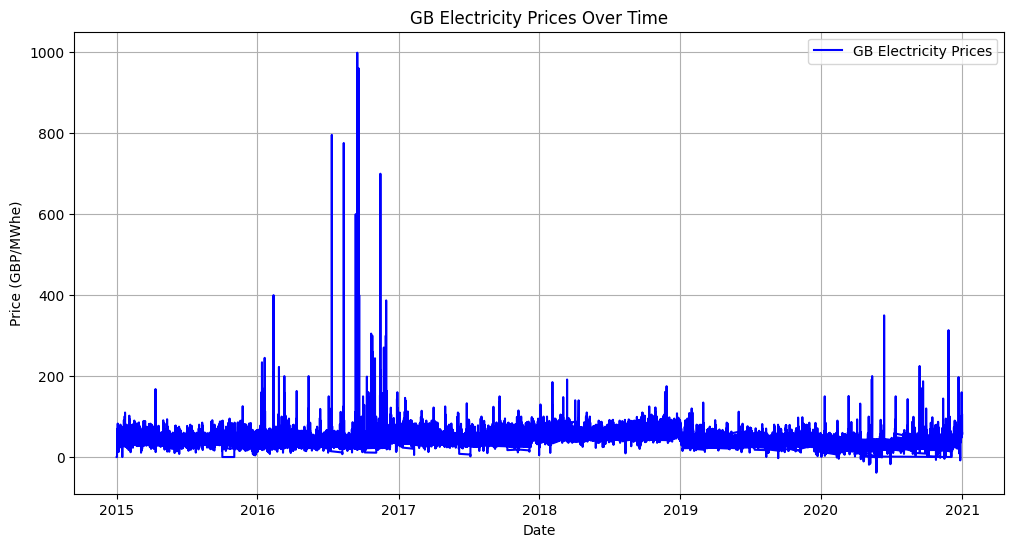

In [62]:
# Plot the GB Prices time series
plt.figure(figsize=(12, 6))
plt.plot(gb_dataset.index, gb_dataset['gb_price'], color='blue', label='GB Electricity Prices')
plt.title('GB Electricity Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (GBP/MWhe)')
plt.grid(True)
plt.legend()
plt.show()

### GB 1 month Time Series

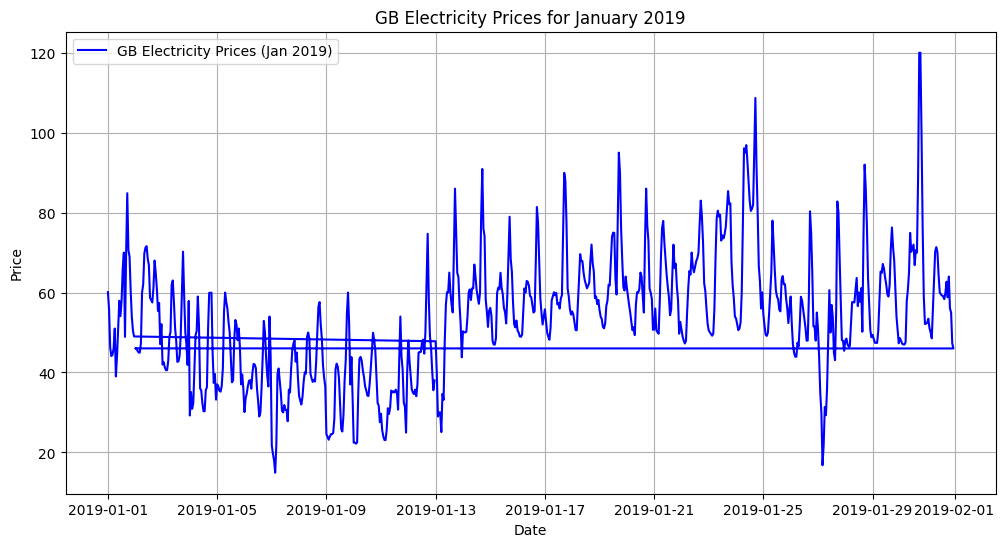

In [65]:
# Filter the DataFrame to include only data for January 2019
january_2019_prices = gb_dataset['2019-01-01':'2019-01-31']

# Plot the time series for January 2019
plt.figure(figsize=(12, 6))
plt.plot(january_2019_prices.index, january_2019_prices['gb_price'], color='blue', label='GB Electricity Prices (Jan 2019)')
plt.title('GB Electricity Prices for January 2019')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

### GB Multiple Days Hourly Time Series

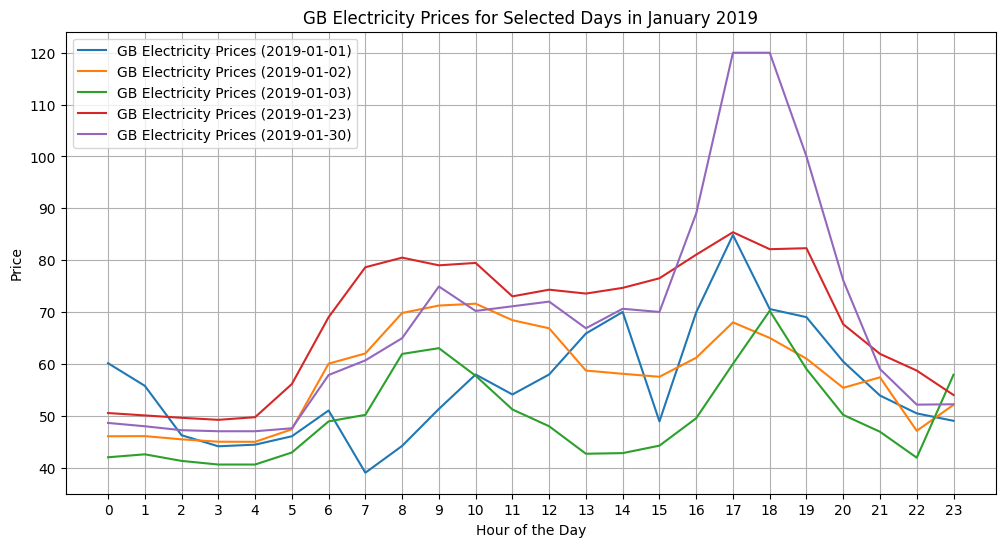

In [89]:
# List of dates to plot
dates_to_plot = ['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-23', '2019-01-30']

# Create a figure for the plot
plt.figure(figsize=(12, 6))

# Loop through each date and plot hourly prices
for date in dates_to_plot:
    # Filter the DataFrame for the specific date
    daily_prices = gb_dataset[gb_dataset['Datetime'].dt.date == pd.to_datetime(date).date()]

    # Extract the hour from the 'Datetime' column
    daily_prices['Hour'] = daily_prices['Datetime'].dt.hour

    # Plot hourly prices for the day
    plt.plot(daily_prices['Hour'], daily_prices['gb_price'], label=f'GB Electricity Prices ({date})')

# Customize the plot
plt.title('GB Electricity Prices for Selected Days in January 2019')
plt.xlabel('Hour of the Day')
plt.ylabel('Price')
plt.grid(True)
plt.legend()

# Show more x-axis ticks
plt.xticks(range(24))  # Show ticks for all 24 hours

# Show the plot
plt.show()


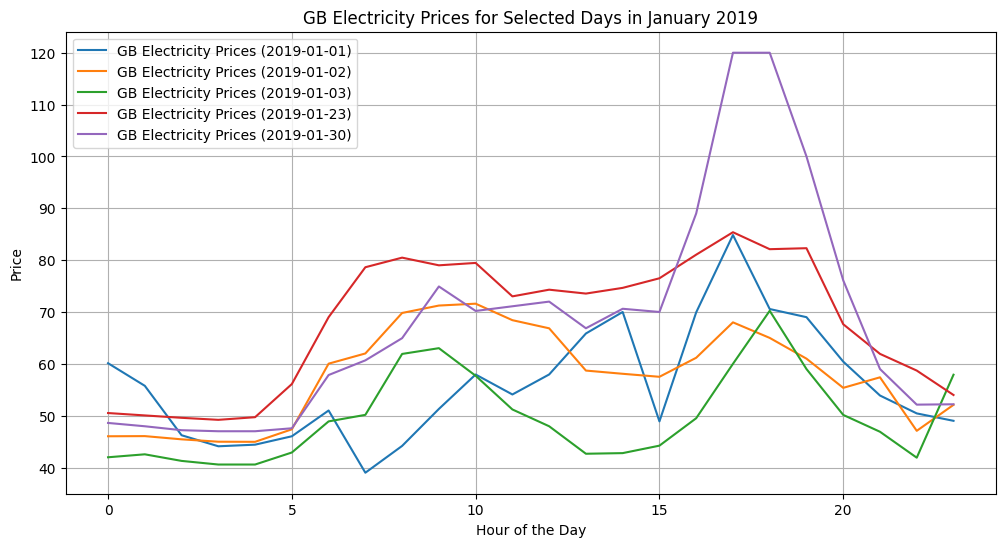

In [85]:
# List of dates to plot
dates_to_plot = ['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-23', '2019-01-30']

# Create a figure for the plot
plt.figure(figsize=(12, 6))

# Loop through each date and plot hourly prices
for date in dates_to_plot:
    # Filter the DataFrame for the specific date
    daily_prices = gb_dataset[gb_dataset['Datetime'].dt.date == pd.to_datetime(date).date()]

    # Extract the hour from the 'Datetime' column
    daily_prices['Hour'] = daily_prices['Datetime'].dt.hour

    # Plot hourly prices for the day
    plt.plot(daily_prices['Hour'], daily_prices['gb_price'], label=f'GB Electricity Prices ({date})')

# Customize the plot
plt.title('GB Electricity Prices for Selected Days in January 2019')
plt.xlabel('Hour of the Day')
plt.ylabel('Price')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


### GB Multiple Years Seasonality

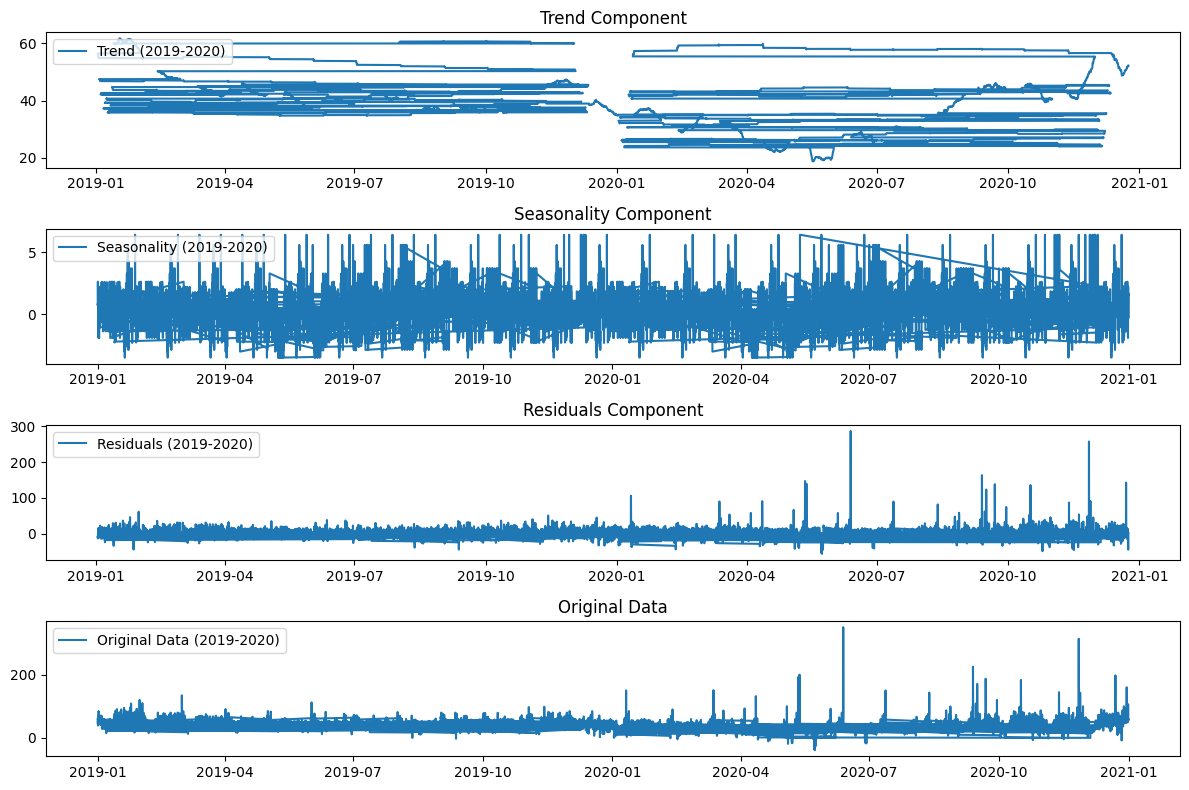

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

# Filter the DataFrame to include data for the years 2019 and 2020
gb_dataset_2019 = gb_dataset[gb_dataset['Datetime'].dt.year == 2019]
gb_dataset_2020 = gb_dataset[gb_dataset['Datetime'].dt.year == 2020]

# Combine the data for both years
combined_data = pd.concat([gb_dataset_2019, gb_dataset_2020])

# Set the 'Datetime' column as the index for the combined dataset
combined_data.set_index('Datetime', inplace=True)

# Fill missing values with linear interpolation
combined_data['gb_price'].interpolate(method='linear', inplace=True)

# Perform seasonal decomposition for the combined data
decomposition_combined = sm.tsa.seasonal_decompose(combined_data['gb_price'], model='additive', period=365)

# Plot the decomposed components for both years
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition_combined.trend, label='Trend (2019-2020)')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(412)
plt.plot(decomposition_combined.seasonal, label='Seasonality (2019-2020)')
plt.legend(loc='upper left')
plt.title('Seasonality Component')

plt.subplot(413)
plt.plot(decomposition_combined.resid, label='Residuals (2019-2020)')
plt.legend(loc='upper left')
plt.title('Residuals Component')

plt.subplot(414)
plt.plot(combined_data['gb_price'], label='Original Data (2019-2020)')
plt.legend(loc='upper left')
plt.title('Original Data')

plt.tight_layout()
plt.show()


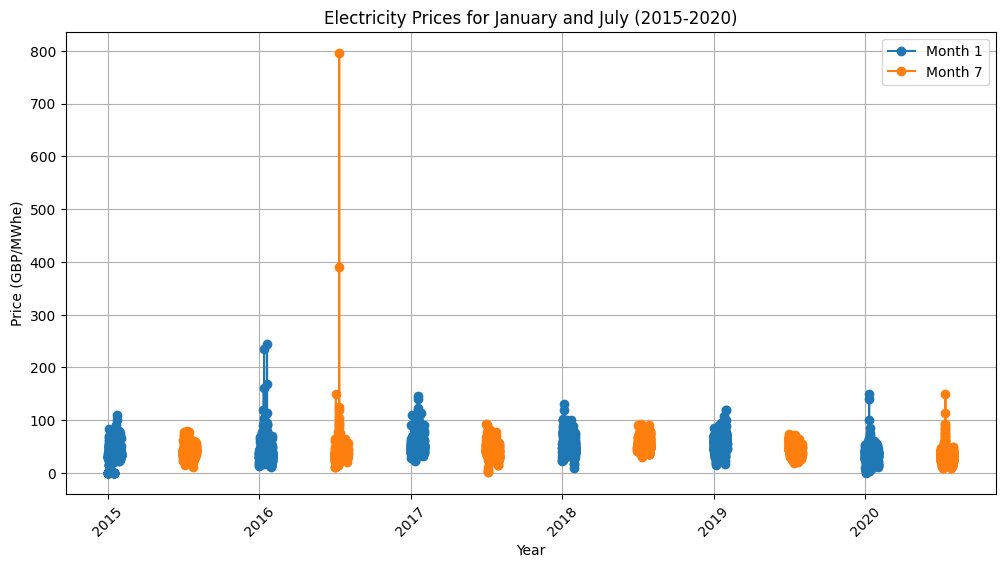

In [100]:
# Filter the DataFrame to include data from 2015 to 2020
gb_dataset_seasonal = gb_dataset[(gb_dataset['Datetime'].dt.year >= 2015) & (gb_dataset['Datetime'].dt.year <= 2020)]

# Extract the month from the 'Datetime' column
gb_dataset_seasonal['Month'] = gb_dataset_seasonal['Datetime'].dt.month

# Define the months of interest (January and July)
months_of_interest = [1, 7]

# Filter the data for the specified months
selected_months_data = gb_dataset_seasonal[gb_dataset_seasonal['Month'].isin(months_of_interest)]

# Group the data by year and month, and calculate the average price for each group
monthly_avg_prices = selected_months_data.groupby(['Datetime', 'Month'])['gb_price'].mean().reset_index()

# Pivot the data to have years as columns and months as rows
pivot_table = monthly_avg_prices.pivot(index='Month', columns='Datetime', values='gb_price')

# Create a line plot to show electricity prices for each January and July
plt.figure(figsize=(12, 6))
for month in months_of_interest:
    plt.plot(pivot_table.columns, pivot_table.loc[month], label=f'Month {month}', marker='o')

plt.title('Electricity Prices for January and July (2015-2020)')
plt.xlabel('Year')
plt.ylabel('Price (GBP/MWhe)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

### Predicted Prices vs. True Prices - LR model

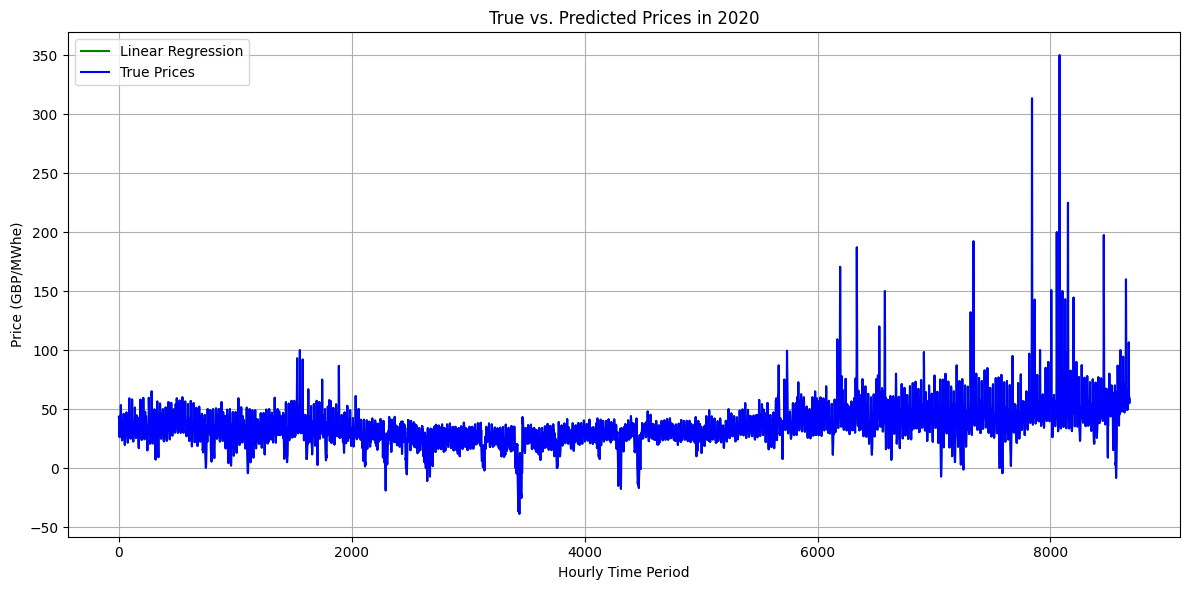

In [186]:
# Sample data for true 2020 hourly prices (replace this with your actual data)
true_prices = test_data['gb_price']

# Sample data for predicted prices by each model (replace these with your actual predictions)
linear_regression_predictions = lr_predicted_2020_prices  # Replace with actual predictions

# Create a list of hours (assuming you have hourly data)
hours = range(1, len(true_prices) + 1)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the predicted prices for each model
ax.plot(hours, linear_regression_predictions, label='Linear Regression', linestyle='-',  color='g')

# Plot the true 2020 hourly prices
ax.plot(hours, true_prices, label='True Prices', linestyle='-', color='b')

# Set plot labels and title
ax.set_xlabel('Hourly Time Period')
ax.set_ylabel('Price (GBP/MWhe)')
ax.set_title('True vs. Predicted Prices in 2020')

# Add a legend
ax.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

### Predicted Prices vs. True Prices - all models

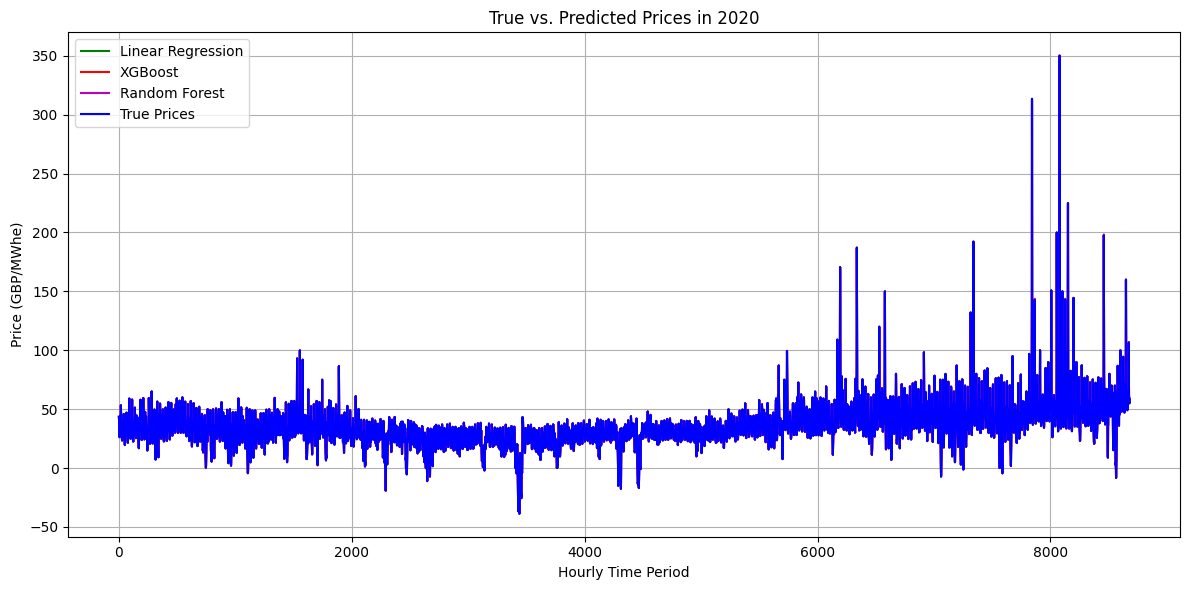

In [185]:
# Sample data for true 2020 hourly prices (replace this with your actual data)
true_prices = test_data['gb_price']

# Sample data for predicted prices by each model (replace these with your actual predictions)
linear_regression_predictions = lr_predicted_2020_prices  # Replace with actual predictions
xgboost_predictions = xgb_predicted_2020_prices # Replace with actual predictions
random_forest_predictions = rf_predicted_2020_prices # Replace with actual predictions

# Create a list of hours (assuming you have hourly data)
hours = range(1, len(true_prices) + 1)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the predicted prices for each model
ax.plot(hours, linear_regression_predictions, label='Linear Regression', linestyle='-',  color='g')
ax.plot(hours, xgboost_predictions, label='XGBoost', linestyle='-', color='r')
ax.plot(hours, random_forest_predictions, label='Random Forest', linestyle='-',  color='m')

# Plot the true 2020 hourly prices
ax.plot(hours, true_prices, label='True Prices', linestyle='-', color='b')

# Set plot labels and title
ax.set_xlabel('Hourly Time Period')
ax.set_ylabel('Price (GBP/MWhe)')
ax.set_title('True vs. Predicted Prices in 2020')

# Add a legend
ax.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

## Appendix

1.   
  - LSTM requires vast amounts of data,
  - LSTM requires data to exhibit stationarity (EDA visualisation showed the stationarity requirement is unlikely to be filled; i.e. mean and variance did not look constant over the time period),
  - LSTM requires data preprocessing, setting sequence length, hyperparameter tuning etc... to get the most out of the technique, without spending time doing this (not possible for this project), the benefits over other techniques are unlikely to be seen
  - Price spikes (such as those seen in 2016) to too rare to be captured in the model accurately,
  - I concluded that ARIMA/machine learning techniques could give good enough results and have fewer requirements.
  
  A commonly used time-series technique is ARIMA modelling - this technique uses it's own historic data to forecast a time series. ARIMA modelling does not make use of the additional features provided. In addition, it requires data to be stationary (no trends or seasonality). I created some visualisations to show the time-series, they show how the data exhibits trends and seasonality where daily prices are highest between 16.00 and 20.00 - this is a trend, another plot shows how typically July prices are cheaper than January prices and a seasonality decomposition shows there is seasonality in the data. For these reasons ARIMA modelling is not suitable. I did however run an ARIMA model during exploration (see below) and the evaluation metrics were poor (low R squared, high RMSE, high MAE - both in absolute terms in relative to the models above) confirming that this technique is ill-suited to this task.

  Therefore machine learning methods were the most suitable. They also allow for multivariate relationships to be explored. I decided to explore linear regression, XGBoost and Random Forest modelling. Linear regression has the advantage of being efficient to run and easy to interpret (with the ability to isolate the impacts of each featute) however it does require several assumptions to be met - linear relationships, lack of outliers so it does require some pre-analysis to be done. XGBoost is a model created to be highly accurate, it works with various types of relationships between outcome and predictor variable, is less sensitive to changing data characteristic and outliers and its model prevents overfitting. It provides is more computationally intensive but running it on Google Colab mitigates this risk. Lastly, I explored Random Forest which shares a number of the advantages XGBoost has.

### Model 4 - ARIMA

In [173]:
# ARIMA model
# Load your data and preprocess it
# For simplicity, let's assume your DataFrame is named 'electricity_data'
# Make sure the 'Datetime' column is of datetime type, and set it as the index

electricity_data = gb_dataset

# Split the data into training and testing datasets based on date
train_data = electricity_data[electricity_data['Datetime'].dt.year < 2020]
test_data = electricity_data[electricity_data['Datetime'].dt.year == 2020]

# Train the ARIMA model
def train_arima_model(train_data, features, order):
    # Create a DataFrame with only the selected features
    train_data = train_data[['Datetime'] + features]

    # Set the 'Datetime' column as the index
    train_data.set_index('Datetime', inplace=True)

    # Create and fit the ARIMA model
    model = ARIMA(train_data['gb_price'], order=order)
    model_fit = model.fit()

    return model_fit

# Define the ARIMA model order (p, d, q)
# You need to tune these hyperparameters based on your data
p, d, q = 1, 1, 1  # Example values

arima_model = train_arima_model(train_data, features, order=(p, d, q))

# Make predictions on the test set
def predict_arima_model(model_fit, test_data, features):
    # Create a DataFrame with only the selected features
    test_data = test_data[['Datetime'] + features]

    # Set the 'Datetime' column as the index
    test_data.set_index('Datetime', inplace=True)

    # Make predictions
    y_pred = model_fit.forecast(steps=len(test_data))

    return y_pred

arima_predictions = predict_arima_model(arima_model, test_data, features)

# Evaluate the ARIMA model
def evaluate_arima_model(test_data, predictions):
    # Calculate RMSE, R-squared, and MAE
    rmse = np.sqrt(mean_squared_error(test_data['gb_price'], predictions))
    r2 = r2_score(test_data['gb_price'], predictions)
    mae = mean_absolute_error(test_data['gb_price'], predictions)

    return rmse, r2, mae

rmse, r2, mae = evaluate_arima_model(test_data, arima_predictions)

# Print evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Optionally, you can train the final ARIMA model on the full dataset
final_arima_model = train_arima_model(electricity_data, features, order=(p, d, q))

# Predict electricity prices for 2020
final_arima_predictions = predict_arima_model(final_arima_model, test_data, features)

# Round predicted prices to 1 decimal place
final_arima_predictions = np.round(final_arima_predictions, 1)

# Create a DataFrame with datetime and predicted prices
arima_results_df = pd.DataFrame({'Datetime': test_data.index, 'Price': final_arima_predictions})

# Save results to CSV
arima_results_df.to_csv(output_path + 'predicted_prices_2020_arima.csv', index=False)

Root Mean Squared Error (RMSE): 16.80
R-squared: -0.02
Mean Absolute Error (MAE): 11.46
